In [117]:
import rdkit
import random
import numpy as np
import pandas as pd
import matplotlib
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import DataStructs

from utils import *
from measures import *
from dataset import Dataset

random.seed(42)
np.random.seed(42)

In [2]:
dataset = Dataset('data/50ActivityClasses_10kCompounds.sdf')
# dataset = Dataset('data/hgnn_cleaned.sdf')
# dataset.load_vecs('data/hgnn_vecs.npy')

100%|█████████▉| 9999/10000 [00:03<00:00, 2735.63it/s]


In [161]:
def define_measures():
    vectorizer = fingerprints
    sim_mat_func = similarity_matrix_tanimoto
#     vectorizer = lambda mols: latent_vectors(mols, dataset=dataset)
#     sim_mat_func = similarity_matrix_latent
    measures = {
        'GS' : GoldenStandard(),
        'Diversity' : Diversity(vectorizer=vectorizer, sim_mat_func=sim_mat_func),
        'SumDiversity' : SumDiversity(vectorizer=vectorizer, sim_mat_func=sim_mat_func),
        'Diameter' : Diameter(vectorizer=vectorizer, sim_mat_func=sim_mat_func),
        'SumDiameter' : SumDiameter(vectorizer=vectorizer, sim_mat_func=sim_mat_func),
        'Bottleneck' : Bottleneck(vectorizer=vectorizer, sim_mat_func=sim_mat_func),
        'SumBottleneck' : SumBottleneck(vectorizer=vectorizer, sim_mat_func=sim_mat_func),
        'DPP' : DPP(vectorizer=vectorizer, sim_mat_func=sim_mat_func),
        '#FG' : NFragment(frag='FG'),
        '#RS' : NFragment(frag='RS'),
        '#BM' : NBM(),
        '#Circles': NCircles(vectorizer=vectorizer, sim_mat_func=sim_mat_func, threshold=0.30),
        'Richness': Richness(),
    }
#     THRESHOLDS = np.linspace(.0, 1., num=26)
#     for t in THRESHOLDS:
#         measures['#Circles (c=%.2f)' % t] = NCircles(
#             vectorizer=vectorizer, sim_mat_func=sim_mat_func, threshold=t)
    return measures

measures = define_measures()
for name, measure in measures.items():
    measure.update(dataset.mols[:100])
    print(name, '\t', measure.report())

GS 	 40
Diversity 	 0.8697320951841289
SumDiversity 	 86.97320951841289
Diameter 	 1.0
SumDiameter 	 95.19528597795286
Bottleneck 	 0.0
SumBottleneck 	 67.62242561421257
DPP 	 2.728983843896072e-78
#FG 	 44
#RS 	 78
#BM 	 98
#Circles 	 83
Richness 	 98


In [242]:
### Setting 1: Random Subsets with Fixed Sizes

def sample_fixed_size(n_class, n_mols):
    targ_subset = np.random.choice(dataset.targets, size=n_class).tolist()
    mols_pool = []
    for targ in targ_subset:
        mols_pool += dataset.targ2idxs[targ]
    random.shuffle(mols_pool)
    subset = [dataset.mols[i] for i in mols_pool[:n_mols]]
    return subset

def random_subset_fixed_size(size=200, n_points=1000, n_runs=10):
    df = pd.DataFrame(columns=['value', 'measure', 'run'])
    
    for run in tqdm(range(n_runs)):
        for _ in range(n_points):
            n_class = np.random.randint(1, 50)
            subset = sample_fixed_size(n_class, size)
            measures = define_measures()
            for name, measure in measures.items():
                measure.update(subset)
                df.loc[df.shape[0]] = [measure.report(), name, run]
    return df

In [243]:
# df = random_subset_fixed_size(size=200, n_runs=10) # size = 50, 200, 1000
# df.to_csv('random_subset_fixed_size=200_fp.csv')
df = pd.read_csv('random_subset_fixed_size=200_fp.csv')
df

,Unnamed: 0,value,measure,run
0,0,11.000000,GS,0
1,1,0.857323,Diversity,0
2,2,171.464577,SumDiversity,0
3,3,0.984615,Diameter,0
4,4,189.572979,SumDiameter,0
...,...,...,...,...
129995,129995,49.000000,#FG,9
129996,129996,105.000000,#RS,9
129997,129997,189.000000,#BM,9
129998,129998,117.000000,#Circles,9


In [229]:
df.loc[df['measure'] == '#Circles (0.35)', 'measure'] = '#Circles'
df

,Unnamed: 0,value,measure,run
0,0,15.000000,GS,0
1,1,0.866991,Diversity,0
2,2,866.990690,SumDiversity,0
3,3,1.000000,Diameter,0
4,4,963.382803,SumDiameter,0
...,...,...,...,...
129995,129995,115.000000,#FG,9
129996,129996,279.000000,#RS,9
129997,129997,815.000000,#BM,9
129998,129998,462.000000,#Circles,9


In [261]:
# correlation

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr as cor

def correlation(df, pairwise=False):
    names = list(define_measures().keys())
    m = len(names)
    n_runs = df.iloc[-1]['run'] + 1
    Cor = np.zeros((m, m, n_runs))
    P = np.zeros((m, m, n_runs))
    for i, name_i in enumerate(names):
        if not pairwise and i > 0: continue
        for j, name_j in enumerate(names):
            for run in range(n_runs):
                a = df[(df['measure'] == name_i) & (df['run'] == run)]['value']
                b = df[(df['measure'] == name_j) & (df['run'] == run)]['value']
                Cor[i,j,run], P[i,j,run] = cor(a, b)
    return Cor

def plot_bar(df, ticks=True):
    Cor = correlation(df)
    
    n_runs = df.iloc[-1]['run'] + 1
    names = list(define_measures().keys())
    df_bar_plot = pd.DataFrame(columns=['measure', 'value'])
    for j, name_j in enumerate(names):
        if j == 0: continue
        for run in range(n_runs):
            df_bar_plot.loc[len(df_bar_plot)] = [name_j, Cor[0,j,run]]
                
    fig = plt.figure(figsize=(8, 4))
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    cls = ['#D9D9D9'] * (len(names) - 1)
    cls[-2] = '#C0E9A2'
    ax = sns.barplot(y='measure', x='value', data=df_bar_plot, palette=cls, orient='h')
    ax.set(ylabel=None)
    ax.set(xlabel='Correlation')
    if not ticks: ax.set_xticks([])
    ax.set(xlim=(-0.3, 1.0))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
    plt.show()
    fig.savefig('fig.pdf', bbox_inches='tight')
    
def plot_t(df):
    Cor = correlation(df)
    
    n_runs = df.iloc[-1]['run'] + 1
    names = list(define_measures().keys())
    df_bar_plot = pd.DataFrame(columns=['threshold', 'value'])
    for j, name_j in enumerate(names):
        if j == 0: continue
        t = float(name_j[-5:-1])
        t = 1. - t
        for run in range(n_runs):
            df_bar_plot.loc[len(df_bar_plot)] = [t, Cor[0,j,run]]
    
    fig = plt.figure(figsize=(8, 4))
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    ax = sns.lineplot(x='threshold', y='value', data=df_bar_plot)
    ax.set(ylabel='Correlation')
    ax.set(xlabel='Threshold t')
#     ax.set(xlim=(0., 1.))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
    fig.savefig('fig.pdf', bbox_inches='tight')
                
def plot_cor(df, Cor=None):
    if Cor is None: 
        Cor = correlation(df, pairwise=True)
    names = list(define_measures().keys())
    
    fig = plt.figure(figsize=(10, 10))
    sns.set(font_scale=1.5)
    g = sns.clustermap(
        Cor.mean(axis=-1), 
        vmin=-1, vmax=1, center=0, 
        annot=False, xticklabels=names, yticklabels=names, fmt='.2f')
    ax = g.ax_heatmap
    ax.tick_params(axis='x', rotation=90)
    plt.show()
    fig = ax.get_figure()
    fig.savefig('fig.pdf', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

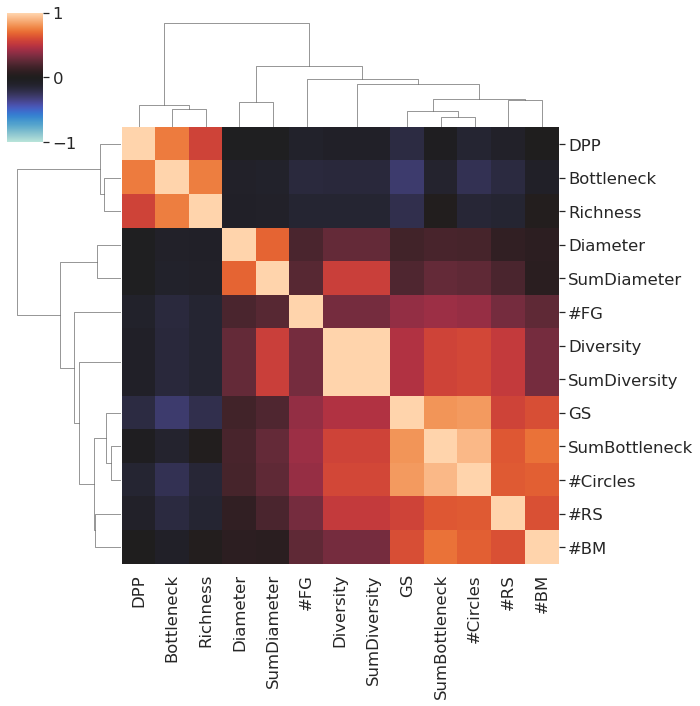

In [262]:
# Cor = correlation(df, pairwise=True)
plot_cor(df, Cor)

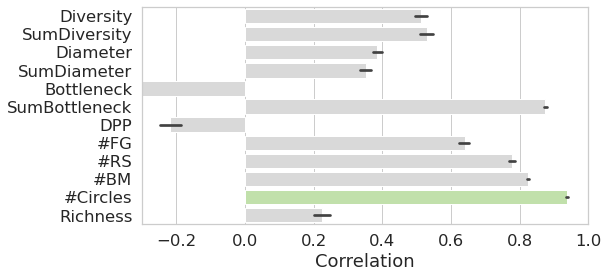

In [230]:
plot_bar(df)

/home/yutxie/miniconda3/envs/em/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


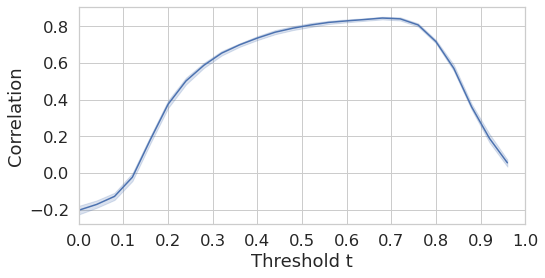

In [154]:
plot_t(df)

In [ ]:
Cor = correlation(df)
names = list(define_measures().keys())
for i, name in enumerate(names):
    print(name, Cor[0,i].mean(), Cor[0,i].std())

In [125]:
### Setting 2: Growing Random Subsets

fps = [fingerprint(mol) for mol in dataset.mols]

def sample_growing(n_mols=1000, power=0):
    N = len(dataset.mols)
    sims = np.array([0.01 for _ in range(N)])
    chosen = np.zeros((N,))
    
    subset = []
    while len(subset) < n_mols:
        p = (sims-chosen)**power
        i = np.random.choice(N, p=p/p.sum())
        sims = np.maximum(sims, similarities_tanimoto(fps[i], fps))
        subset.append(i)
        chosen[i] = 1
        
    subset = [dataset.mols[i] for i in subset]
    return subset

def random_subset_growing(n_mols=1000, power=0, n_runs=10):
    df_list = []
    for run in tqdm(range(n_runs)):
        subset = sample_growing(n_mols, power=power)
        
        data = []
        measures = define_measures()
        for i, mol in enumerate(subset):
            for name, measure in measures.items():
                measure.update([mol])
                data.append([i+1, measure.report(), name, run])
        
        df = pd.DataFrame(data=data, columns=['n_mols', 'value', 'measure', 'run'])
        
        ymax = None
        for name in measures.keys():
            y = df[df['measure'] == name]['value'].to_numpy()
            if name == 'GS': ymax = y.max()
            if y.max() > 0:
                df.loc[df['measure'] == name, 'value'] = y / y.max() * ymax
        df_list.append(df)
    
    df = pd.concat(df_list)
    return df

In [263]:
# df = random_subset_growing(power=0)
# df.to_csv('random_subset_growing_power=0_fp.csv')
df = pd.read_csv('random_subset_growing_power=10_fp.csv')
df

,Unnamed: 0,n_mols,value,measure,run
0,0,1,1.0,GS,0
1,1,1,0.0,Diversity,0
2,2,1,0.0,SumDiversity,0
3,3,1,0.0,Diameter,0
4,4,1,0.0,SumDiameter,0
...,...,...,...,...,...
129995,12995,1000,39.0,#FG,9
129996,12996,1000,39.0,#RS,9
129997,12997,1000,39.0,#BM,9
129998,12998,1000,39.0,#Circles (0.24),9


In [264]:
df.loc[df['measure'] == '#Circles (0.24)', 'measure'] = '#Circles'
df

,Unnamed: 0,n_mols,value,measure,run
0,0,1,1.0,GS,0
1,1,1,0.0,Diversity,0
2,2,1,0.0,SumDiversity,0
3,3,1,0.0,Diameter,0
4,4,1,0.0,SumDiameter,0
...,...,...,...,...,...
129995,12995,1000,39.0,#FG,9
129996,12996,1000,39.0,#RS,9
129997,12997,1000,39.0,#BM,9
129998,12998,1000,39.0,#Circles,9


In [269]:
from tslearn.metrics import dtw

def correlation(df, pairwise=False):
    names = list(define_measures().keys())
    m = len(names)
    n_runs = df.iloc[-1]['run'] + 1
    Cor = np.zeros((m, m, n_runs))
    P = np.zeros((m, m, n_runs))
    for i, name_i in enumerate(names):
        if not pairwise and i > 0: continue
        for j, name_j in enumerate(names):
            for run in range(n_runs):
                a = df[(df['measure'] == name_i) & (df['run'] == run)]['value'].to_numpy()
                b = df[(df['measure'] == name_j) & (df['run'] == run)]['value'].to_numpy()
                a = a[1:] - a[:-1]
                b = b[1:] - b[:-1]
                Cor[i,j,run] = dtw(a, b) # dtw distance
    return Cor

def plot_bar(df, ticks=True):
    Cor = correlation(df)
    
    n_runs = df.iloc[-1]['run'] + 1
    names = list(define_measures().keys())
    df_bar_plot = pd.DataFrame(columns=['measure', 'value'])
    for j, name_j in enumerate(names):
        if j == 0: continue
        for run in range(n_runs):
            df_bar_plot.loc[len(df_bar_plot)] = [name_j, Cor[0,j,run]]
                
    fig = plt.figure(figsize=(8, 4))
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    cls = ['#D9D9D9'] * (len(names) - 1)
    cls[-2] = '#C0E9A2'
    ax = sns.barplot(y='measure', x='value', data=df_bar_plot, palette=cls, orient='h')
    ax.set(ylabel=None)
    ax.set(xlabel='DTW distance')
    ax.set_xscale("log")
    ax.set_xticks([1,2,3,5,10,50])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if not ticks: ax.set_xticks([])
    plt.show()
    fig.savefig('fig.pdf', bbox_inches='tight')
    
    
def plot_t(df):
    Cor = correlation(df)
    
    n_runs = df.iloc[-1]['run'] + 1
    names = list(define_measures().keys())
    df_bar_plot = pd.DataFrame(columns=['threshold', 'value'])
    for j, name_j in enumerate(names):
        if j == 0: continue
        t = float(name_j[-5:-1])
        t = 1. - t
        for run in range(n_runs):
            df_bar_plot.loc[len(df_bar_plot)] = [t, Cor[0,j,run]]
    
    fig = plt.figure(figsize=(8, 4))
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    ax = sns.lineplot(x='threshold', y='value', data=df_bar_plot)
    ax.set(ylabel='DTW distance')
    ax.set(xlabel='Threshold t')
    ax.set(xlim=(0.7, 0.9))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.05))
    fig.savefig('fig.pdf', bbox_inches='tight')
    
def plot_cor(df, Cor=None):
    if Cor is None: 
        Cor = correlation(df, pairwise=True)
    names = list(define_measures().keys())
    
    fig = plt.figure(figsize=(10, 10))
    sns.set(font_scale=1.5)
    g = sns.clustermap(
        Cor.mean(axis=-1), 
        vmin=0, vmax=10, 
        annot=False, xticklabels=names, yticklabels=names, fmt='.2f')
    ax = g.ax_heatmap
    ax.tick_params(axis='x', rotation=90)
    plt.show()
    fig = ax.get_figure()
    fig.savefig('fig.pdf', bbox_inches='tight')

/home/yutxie/miniconda3/envs/em/lib/python3.8/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 720x720 with 0 Axes>

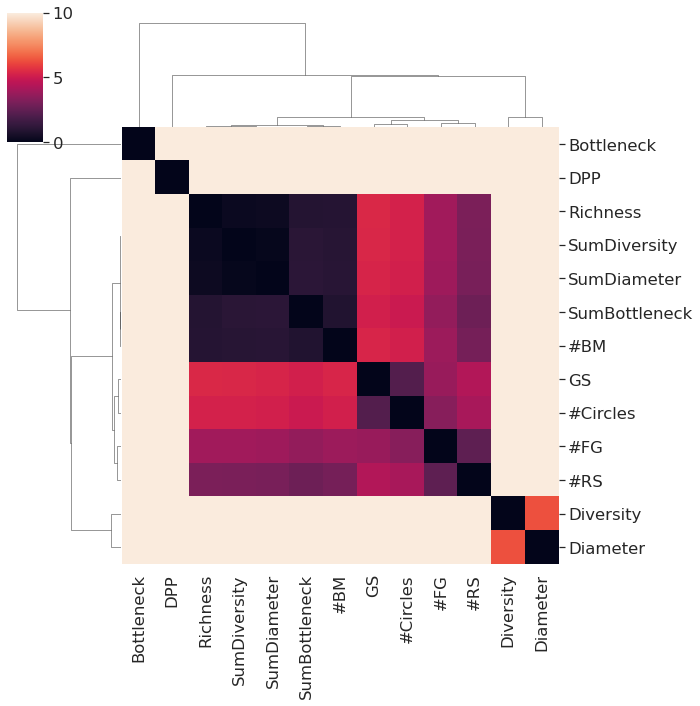

In [270]:
# Cor = correlation(df, pairwise=True)
plot_cor(df, Cor)

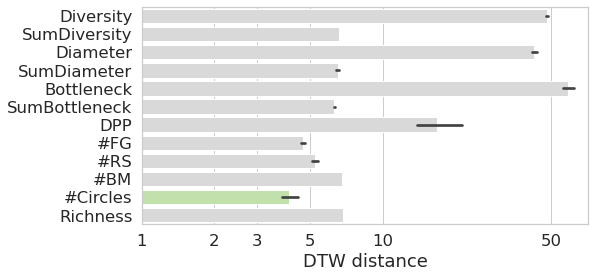

In [241]:
plot_bar(df)

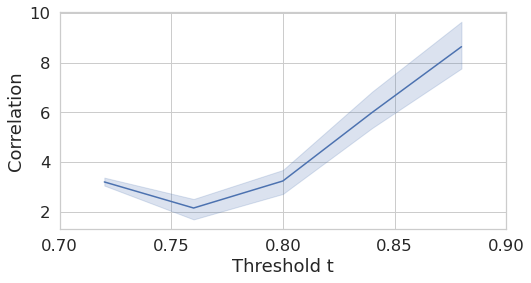

In [160]:
plot_t(df)

In [10]:
Cor = correlation(df)
names = list(define_measures().keys())
for i, name in enumerate(names):
    print(name, Cor[0,i].mean(), Cor[0,i].std())

GS 0.0 0.0
Diversity 18.66842206648905 6.9733929563404535
SumDiversity 5.425040639996768 0.40387114188710116
Diameter 17.299115935682025 4.800817168996043
SumDiameter 5.327635230206658 0.39639985519484644
Bottleneck 38.667951333414386 5.769350360212175
SumBottleneck 5.166891967740236 0.3534880349939561
DPP 18.84509906050829 3.9623232980851024
#FG 3.7965078901387392 0.29518819044215167
#RS 4.382480192690104 0.24720410891113626
#BM 5.364794899494538 0.3964915899355183
#Circles (0.24) 2.1730213768167372 0.3302411302285346
Richness 5.454351437401783 0.4083933640115078


In [ ]:
df2[df2['measure'] == 'Bottleneck']
Cor[0,3,[0,1,2,3,4,5,7,8,9]].std()

In [ ]:
plot_ts_sim(df1)
plot_ts_sim(df2)
plot_ts_sim(df3)

In [ ]:
# plot_curve(df1)
plot_curve(df2)
# plot_curve(df3)